### Mathieu Alain  ~~ August 2019

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

from torch.autograd import Variable
import matplotlib.pyplot as plt

pyro.set_rng_seed(42)

## Dataset Generation

In [2]:
N = 250 # Size of the dataset
X_data = torch.rand(N,1) # Sampling of N uniformly distributed points
a, b = 10, 2
sigma = 2 
Y_data = a * X_data + b + dist.Normal(loc=0, scale=sigma).sample([N,1]) # Computing Y_data with normal noise

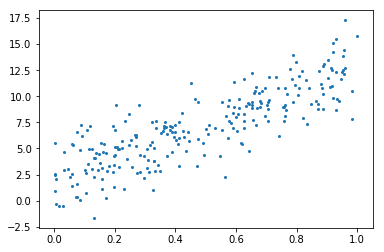

In [3]:
plt.scatter(X_data.numpy(), Y_data.numpy(), s=4)

## Neural Network Model

In [4]:
class NNModel(nn.Module):
    
    
    def __init__(self, input_dim, output_dim):
        super(NNModel, self).__init__() 
        self.L1 = nn.Linear(input_dim, output_dim) 
        
        
    def forward(self, x):
        output = self.L1(x)
        return output

## Pyro Model

In [5]:
def model(x):
    
    L1w_prior = dist.Normal(loc=torch.zeros_like(Net.L1.weight), scale=torch.ones_like(Net.L1.weight))
    L1b_prior = dist.Normal(loc=torch.zeros_like(Net.L1.bias), scale=torch.ones_like(Net.L1.bias))
    sigma = pyro.sample('sigma', dist.Uniform(0,2))

    priors = {'L1.weight': L1w_prior, 'L1.bias': L1b_prior, 'sigma': sigma}
    
    
    lifted_module = pyro.random_module("module", Net, priors)
    lifted_net = lifted_module()
    

    with pyro.plate("map", len(x)):
        prediction = lifted_net(x)
        pyro.sample("obs", dist.Normal(prediction, sigma))
        return prediction

In [6]:
def conditioned_model(model, x, y):
    return poutine.condition(model, data={"obs":y})(x)

## Execution

In [7]:
Net = NNModel(1,1)

In [8]:
nuts_kernel = NUTS(conditioned_model)
mcmc = MCMC(nuts_kernel, num_samples=150, warmup_steps=0, num_chains=1)

In [9]:
mcmc.run(model, X_data, Y_data)
mcmc.summary()

sample: 100%|██████████| 150/150 [00:34<00:00,  1.62it/s, step size=1.95e-03, acc. prob=0.953]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                  sigma      1.95      0.02      1.95      1.94      1.97     14.26      1.00
module$$$L1.weight[0,0]      7.66      2.73      7.32      3.48     10.67      2.60      2.68
    module$$$L1.bias[0]      3.28      1.17      3.64      1.94      4.88      2.69      2.71




## Samples 

In [10]:
samples = mcmc.get_samples()
weight = samples['module$$$L1.weight'].numpy()
weight = weight.reshape(weight.shape[0],1)
bias = samples['module$$$L1.bias'].numpy()

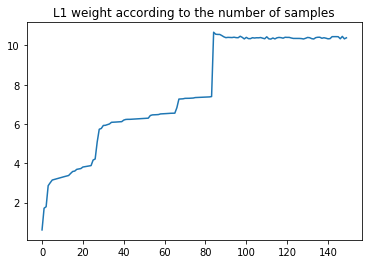

In [11]:
plt.title("L1 weight according to the number of samples")
plt.plot(weight)

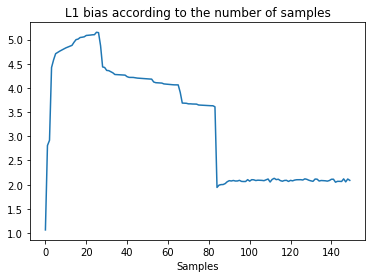

In [12]:
plt.title("L1 bias according to the number of samples")
plt.xlabel('Samples')
plt.plot(bias)

In [13]:
from pyro.infer.mcmc.util import predictive
samples = mcmc.get_samples()

In [14]:
print(samples['sigma'].shape)
print(samples['module$$$L1.weight'].shape)
print(samples['module$$$L1.bias'].shape)

torch.Size([150])
torch.Size([150, 1, 1])
torch.Size([150, 1])


In [15]:
samples['module$$$L1.weight'] = samples['module$$$L1.weight'].view(250,1)

RuntimeError: shape '[250, 1]' is invalid for input of size 150

In [16]:
trace = predictive(conditioned_model, samples, model, X_data, Y_data, return_trace=True)

/home/mathieu/anaconda3/lib/python3.7/site-packages/pyro/infer/mcmc/util.py:502: ExperimentalWarning: This function or its interface might change in the future.
  ExperimentalWarning)


RuntimeError: t() expects a tensor with <= 2 dimensions, but self is 3D
               Trace Shapes:              
                Param Sites:              
               Sample Sites:              
_num_predictive_samples dist             |
                       value         150 |
                  sigma dist     150   1 |
                       value     150   1 |
     module$$$L1.weight dist     150   1 |
                       value 150   1   1 |
       module$$$L1.bias dist     150   1 |
                       value     150   1 |
                    map dist             |
                       value         250 |

In [ ]:
trace.compute_log_prob()

In [ ]:
trace.nodes.keys()

In [ ]:
log_prob = trace.nodes['obs']['log_prob']

In [ ]:
plt.plot(-0.025*torch.sum(log_prob, dim=0).numpy())